# Предсказание выручки сетевых ресторанов

**Дано:** Информация о выручке ресторанов одной из сетей ресторанов в 20 городах за 2010-2011 год

**Задача:** Предсказать размер выручки за 2012 год

**Данные:**
* restaurants.csv – список 20 городов
* data.csv – дополнительные данные о городах, разделенные по неделям: температура, стоимость топлива, уровень безработицы, и является ли эта неделя праздничной (на праздничных неделях посещение ресторанов значительно увеличивается)
* train.csv – данные по выручке ресторанов, объединенных по городам (в одном городе находится несколько ресторанов)
* test.csv – датасет, который необходимо дополнить предсказанными данными

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
sns.set_palette('viridis')
sns.set_style('whitegrid',
              {'axes.facecolor': '1',
               'axes.edgecolor': '0.1',
               'axes.labelcolor': '0.2',
               'text.color': '0.2',
               'xtick.color': '0.2',
               'ytick.color': '0.2',
               'grid.color': '0.7',
               'figure.facecolor': '0.95',}
             )

sns.set_context('notebook', font_scale=1.3)

plt.rcParams.update({
    'legend.fancybox': True,
    'legend.fontsize': 14,
    'legend.framealpha': 0.8,
    'legend.frameon': True,
    'legend.shadow': True,
    'legend.title_fontsize': 15,
    'figure.figsize': (10, 6)
})

---

## Загрузка данных

### Список 20 городов с численностью населения

In [3]:
cities = pd.read_csv('restaurants.csv')
cities.columns = ['city', 'city_size']
cities.head()

city  city_size
0     1     151315
1     2     202307
2     3      37392
3     4     205863
4     5      34875

In [4]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   city       20 non-null     int64
 1   city_size  20 non-null     int64
dtypes: int64(2)
memory usage: 448.0 bytes


In [5]:
cities.duplicated().sum()

0

Нет дубликатов и пропущенных значений.

In [6]:
# всего разных городов
cities.city.nunique()

20

In [7]:
cities['city_size'].describe()

count        20.000000
mean     142749.300000
std       61683.245197
min       34875.000000
25%      107475.500000
50%      138913.500000
75%      202814.250000
max      219622.000000
Name: city_size, dtype: float64

Не очень большие города в списке.

----

### Дополнительные данные о городах

**Дополнительные данные о городах, разделенные по неделям: температура, стоимость топлива, уровень безработицы, и является ли эта неделя праздничной (на праздничных неделях посещение ресторанов значительно увеличивается)**

In [8]:
meta_data = pd.read_csv('data.csv', parse_dates=[1])
meta_data.columns = [x.lower() for x in meta_data.columns]
meta_data.head()

city       date  temperature  fuel_price  unemployment  isholiday
0     1 2010-05-02        42.31       2.572         8.106      False
1     1 2010-12-02        38.51       2.548         8.106       True
2     1 2010-02-19        39.93       2.514         8.106      False
3     1 2010-02-26        46.63       2.561         8.106      False
4     1 2010-05-03        46.50       2.625         8.106      False

In [9]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 0 to 3639
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   city          3640 non-null   int64         
 1   date          3640 non-null   datetime64[ns]
 2   temperature   3640 non-null   float64       
 3   fuel_price    3640 non-null   float64       
 4   unemployment  3380 non-null   float64       
 5   isholiday     3640 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1)
memory usage: 145.9 KB


In [10]:
meta_data.describe()

city  temperature   fuel_price  unemployment
count  3640.000000  3640.000000  3640.000000   3380.000000
mean     10.500000    59.166354     3.378593      7.414191
std       5.767074    18.788846     0.427207      1.678688
min       1.000000    -7.290000     2.514000      3.879000
25%       5.750000    45.872500     3.015500      6.380000
50%      10.500000    60.640000     3.479000      7.290000
75%      15.250000    73.967500     3.707500      8.106000
max      20.000000   101.950000     4.468000     14.313000

In [11]:
meta_data.duplicated().sum()

0

Дубликатов нет, пропущенные значения только в одной колонке unemployment:

In [12]:
meta_data.unemployment.isnull().sum()

260

Пропущенные значения встречаются для следующих дат:

In [13]:
meta_data.loc[meta_data.unemployment.isnull(), 'date'].unique()

array(['2013-03-05T00:00:00.000000000', '2013-10-05T00:00:00.000000000',
       '2013-05-17T00:00:00.000000000', '2013-05-24T00:00:00.000000000',
       '2013-05-31T00:00:00.000000000', '2013-07-06T00:00:00.000000000',
       '2013-06-14T00:00:00.000000000', '2013-06-21T00:00:00.000000000',
       '2013-06-28T00:00:00.000000000', '2013-05-07T00:00:00.000000000',
       '2013-12-07T00:00:00.000000000', '2013-07-19T00:00:00.000000000',
       '2013-07-26T00:00:00.000000000'], dtype='datetime64[ns]')

Все пропуски для 2013 года, поэтому можно удалить - это вне временных рамок нашей задачи. Удалим в целом все, что для 2013 года, так как это лишняя для нас информация:

In [14]:
meta_data = meta_data[meta_data['date'] < '2013-01-01']

In [15]:
meta_data.isnull().sum()

city            0
date            0
temperature     0
fuel_price      0
unemployment    0
isholiday       0
dtype: int64

In [16]:
meta_data.date.min(), meta_data.date.max()

(Timestamp('2010-01-10 00:00:00'), Timestamp('2012-12-28 00:00:00'))

Эти метаданные содержат в том числе и данные для тестового периода (2012 год).

Посмотрим, как меняется уровень безработицы с течением времени:

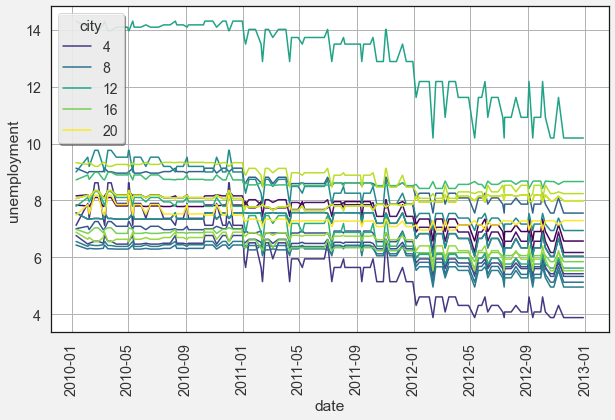

In [17]:
sns.lineplot(data=meta_data, x='date', y='unemployment', hue='city', palette='viridis')
plt.xticks(rotation=90)
plt.show()

Уровень безработицы в 2010 году держится примерно на одном уровне, а в 2011 году постепенно, но не равномерно, снижается.

----

### Данные о выручке ресторанов

In [18]:
train = pd.read_csv('train.csv', parse_dates=[2])
train.columns = [x.lower() for x in train.columns]
train.head()

city  restaurant       date  weekly_sales  isholiday
0     1           1 2010-05-02      24924.50      False
1     1           1 2010-12-02      46039.49       True
2     1           1 2010-02-19      41595.55      False
3     1           1 2010-02-26      19403.54      False
4     1           1 2010-05-03      21827.90      False

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137938 entries, 0 to 137937
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   city          137938 non-null  int64         
 1   restaurant    137938 non-null  int64         
 2   date          137938 non-null  datetime64[ns]
 3   weekly_sales  137938 non-null  float64       
 4   isholiday     137938 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 4.3 MB


In [20]:
train.duplicated().sum()

0

In [21]:
train.city.nunique()

20

In [22]:
train.describe()

city     restaurant   weekly_sales
count  137938.000000  137938.000000  137938.000000
mean       10.528919      43.511679   18113.668509
std         5.786785      29.635082   25831.172755
min         1.000000       1.000000   -1098.000000
25%         6.000000      19.000000    2772.745000
50%        11.000000      36.000000    8598.760000
75%        15.000000      71.000000   22275.440000
max        20.000000      99.000000  693099.360000

In [23]:
train = train.sort_values(by=['city','restaurant','date'])

Мы имеем дело не с временными рядами в строгом смысле, так как "измерения" проводились с неравными промежутками:

In [24]:
train_dates = np.sort(train.date.dt.date.unique())
train_intervals = []
for i in range(1, len(train_dates)):
    train_intervals.append(train_dates[i] - train_dates[i-1])
train_intervals = pd.Series(train_intervals)
train_intervals.describe()

count                           99
mean     7 days 06:18:10.909090909
std      3 days 10:28:12.761884437
min                1 days 00:00:00
25%                6 days 00:00:00
50%                7 days 00:00:00
75%                8 days 00:00:00
max               25 days 00:00:00
dtype: object

В среднем, измерения проводились раз в неделю, но стандартное отклонение составляет 3 дня. Встречается "измерение", которое было получено через 25 дней от предыдущего.

#### Сколько ресторанов  в каждом городе

In [25]:
for i in range(1,21):
    print(f"city {i} has {train.loc[train['city']==i, 'restaurant'].nunique()} restaurants")

city 1 has 77 restaurants
city 2 has 78 restaurants
city 3 has 71 restaurants
city 4 has 78 restaurants
city 5 has 72 restaurants
city 6 has 77 restaurants
city 7 has 75 restaurants
city 8 has 75 restaurants
city 9 has 72 restaurants
city 10 has 77 restaurants
city 11 has 78 restaurants
city 12 has 74 restaurants
city 13 has 79 restaurants
city 14 has 77 restaurants
city 15 has 78 restaurants
city 16 has 75 restaurants
city 17 has 75 restaurants
city 18 has 78 restaurants
city 19 has 78 restaurants
city 20 has 78 restaurants


#### Как выглядят "временные ряды" ресторанов в каждом городе

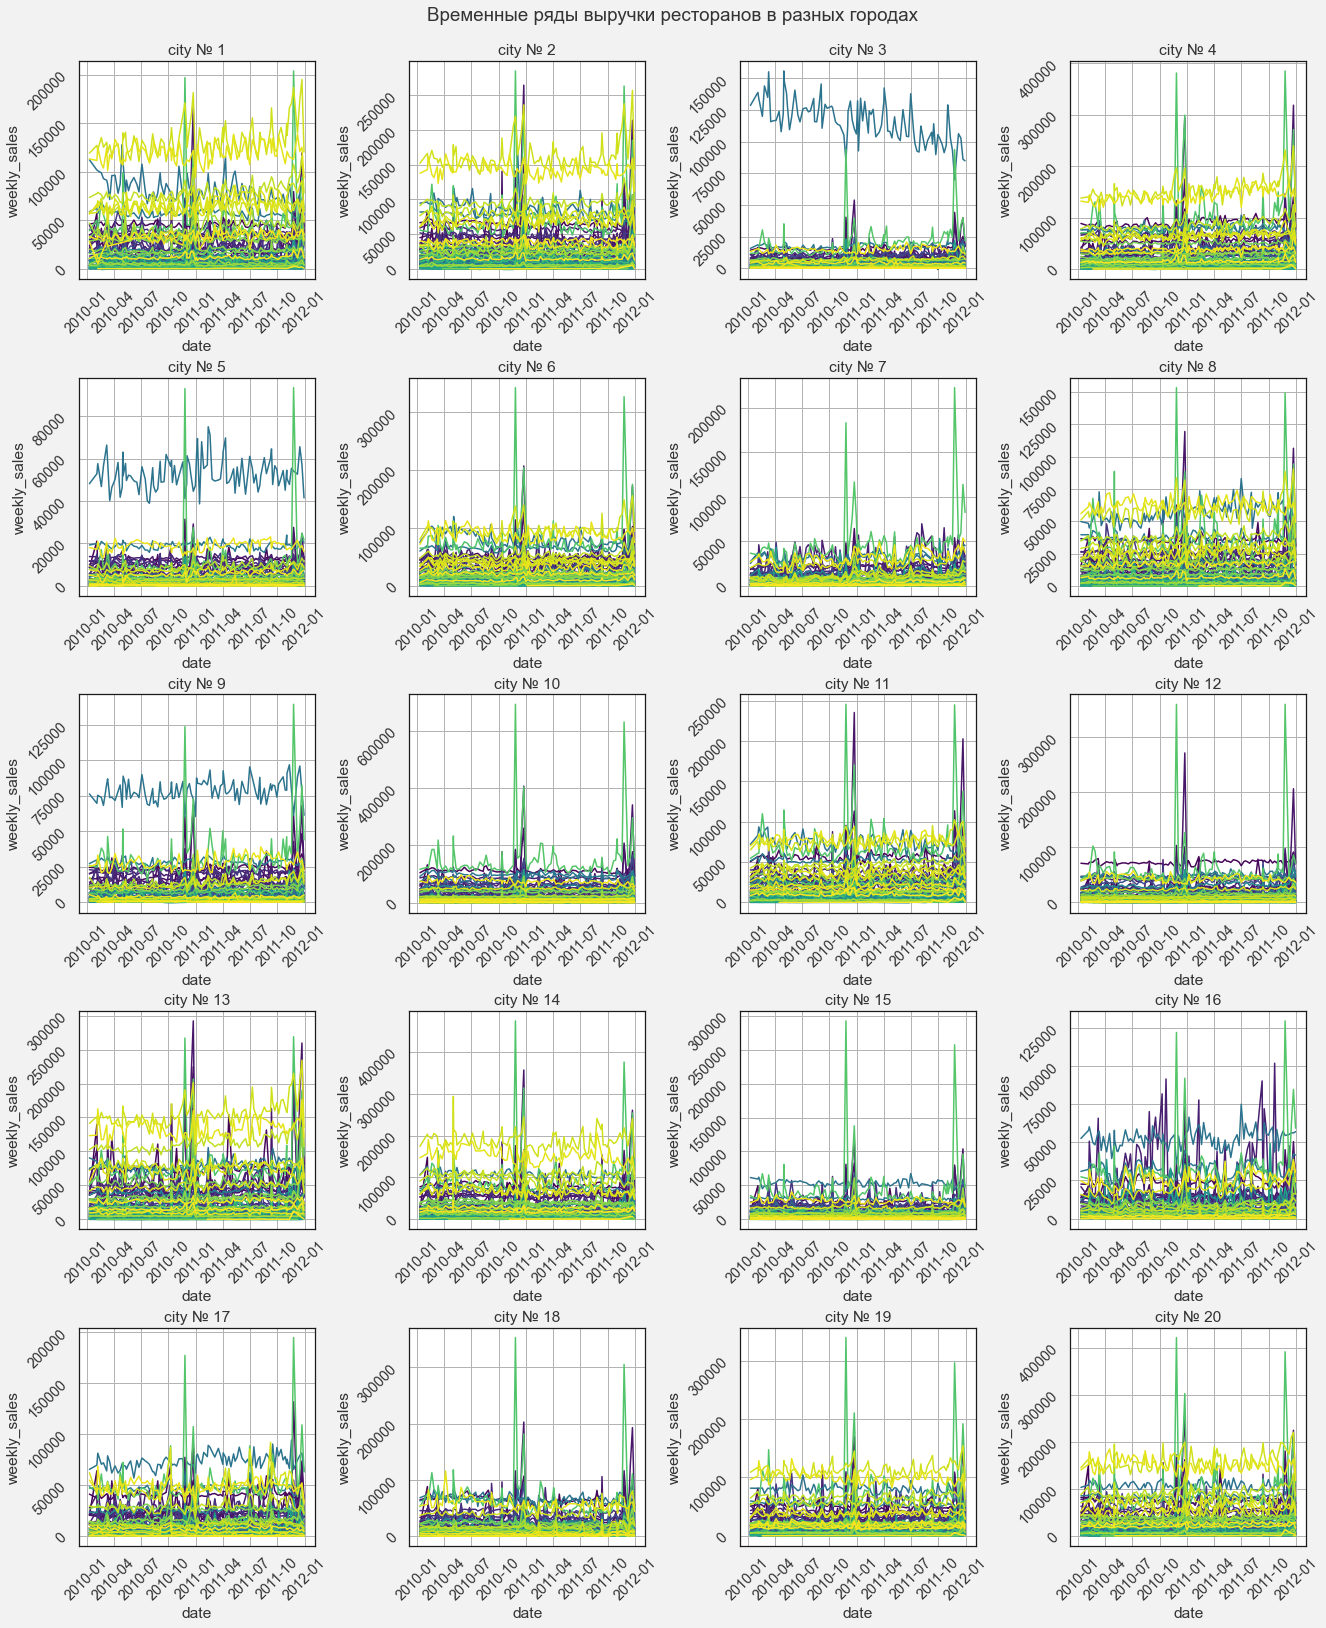

In [26]:
fig, ax = plt.subplots(5,4, figsize=(22,25))
for i in range(0,20):
    sns.lineplot(ax=ax[i//4, i%4],
                 data=train[(train['city']==i+1)],
                 x='date',
                 y='weekly_sales',
                 hue='restaurant',
                 palette='viridis')
    ax[i//4, i%4].set_title(f'city № {str(i+1)}')
    ax[i//4, i%4].get_legend().remove()
    ax[i//4, i%4].tick_params(labelrotation=45)
    
plt.subplots_adjust(top=0.95, wspace=0.4, hspace=0.45)
plt.suptitle('Временные ряды выручки ресторанов в разных городах')
plt.show()

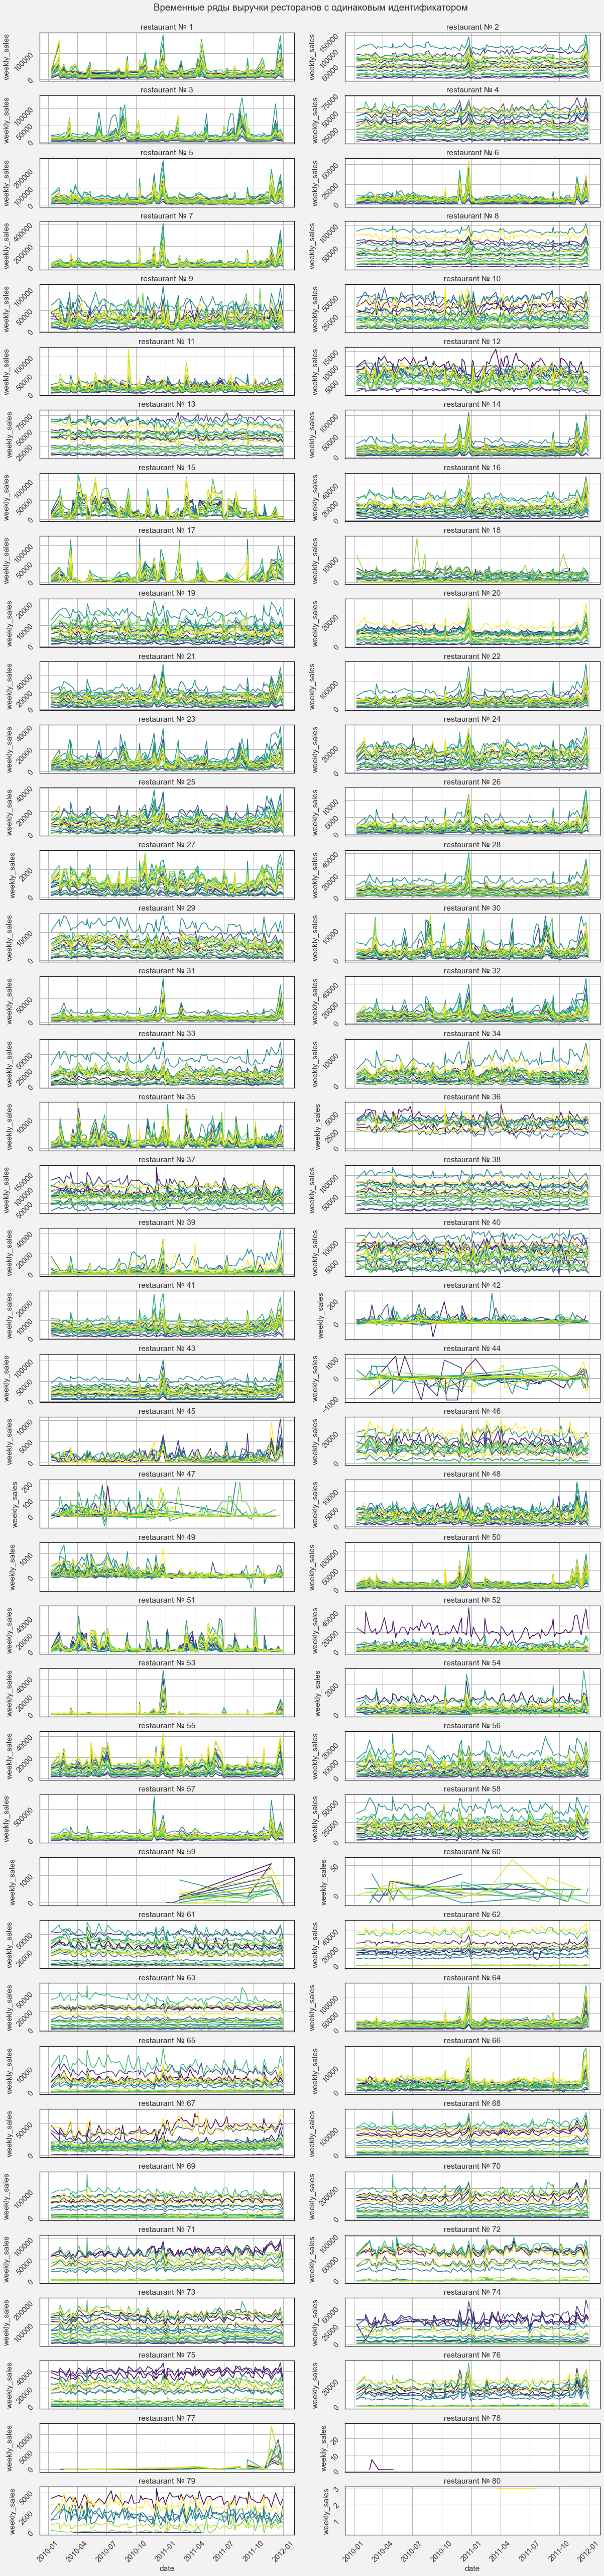

In [27]:
fig, ax = plt.subplots(40,2, figsize=(20, 80), sharex=True)
for i, r in enumerate(train['restaurant'].unique()):
    sns.lineplot(ax=ax[i//2, i%2],
                 data=train[train['restaurant']==r],
                 x='date',
                 y='weekly_sales',
                 hue='city',
                 palette='viridis')
    ax[i//2, i%2].set_title(f'restaurant № {str(i+1)}')
    ax[i//2, i%2].get_legend().remove()
    ax[i//2, i%2].tick_params(labelrotation=45)
    
plt.subplots_adjust(top=0.99, wspace=0.2, hspace=0.3)
plt.suptitle('Временные ряды выручки ресторанов с одинаковым идентификатором', y=1)
plt.show()

Профили ресторанов с одинаковым номером в разных городах в основном сильно похожи (какова природа присвоения идентификаторов?). А вот рестораны внутри одного города различаются сильно. Так же на графиках хорошо видна годовая сезонность - ближе к концу года имеется пик (у нас 2 года, поэтому 2 пика).

#### Удаление аномальных ресторанов

По графикам видно, что есть рестораны с очень малым количеством "измерений". Удалим эти рестораны из обучающей выборки, как "аномальные":

In [28]:
train.shape

(137938, 5)

In [29]:
too_little_measurements = []
for c in train.city.unique():
    for r in train.loc[train['city']==c, 'restaurant'].unique():
        num_measurements = train[(train['city']==c)&(train['restaurant']==r)].shape[0]
        if num_measurements < 52*2*0.5: #посчитаем те, у которых число "измерений" прибыли меньше половины от эталонного (измерение каждую неделю)
            too_little_measurements.append((c, r))
print(len(too_little_measurements))

142


In [30]:
anomal_train_data = pd.DataFrame(columns=train.columns)
for c, r in too_little_measurements:
    anomal_train_data = pd.concat([anomal_train_data, train[(train.city == c) & (train.restaurant == r)]], axis=0)
    train = train.drop(train[(train.city == c) & (train.restaurant == r)].index)

In [31]:
anomal_train_data.shape

(1900, 5)

In [32]:
train.shape

(136038, 5)

In [33]:
train.city.nunique(), train.restaurant.nunique()

(20, 74)

----

### Тестовые данные

In [34]:
test = pd.read_csv('test.csv', parse_dates=[2])
test.columns = [x.lower() for x in test.columns]
test.head()

city  restaurant       date  isholiday
0     1           1 2012-06-01      False
1     1           1 2012-01-13      False
2     1           1 2012-01-20      False
3     1           1 2012-01-27      False
4     1           1 2012-03-02      False

In [35]:
test_dates = np.sort(test.date.dt.date.unique())
test_intervals = []
for i in range(1, len(test_dates)):
    test_intervals.append(test_dates[i] - test_dates[i-1])
test_intervals = pd.Series(test_intervals)
test_intervals.describe()

count                           42
mean     8 days 01:42:51.428571428
std      4 days 20:39:46.835035084
min                3 days 00:00:00
25%                7 days 00:00:00
50%                7 days 00:00:00
75%                8 days 00:00:00
max               35 days 00:00:00
dtype: object

В тесте такая же ситуация с интервалами, значит принимаем это как данность и будем извлекать из дат признаки, а так же использовать их как ряды, для построения других признаков, типа скользящего среднего, как и для обычных временных рядов.

In [36]:
test.shape

(59611, 4)

In [37]:
anomal_test_data = pd.DataFrame(columns=test.columns)
for c, r in too_little_measurements:
    anomal_test_data = pd.concat([anomal_test_data, test[(test['city'] == c)&(test['restaurant']==r)]], axis=0)
    test = test.drop(test[(test.city == c) & (test.restaurant == r)].index)

In [38]:
test.shape

(58270, 4)

In [39]:
anomal_test_data.shape

(1341, 4)

In [40]:
test.city.nunique(), test.restaurant.nunique()

(20, 77)

В тесте встречаются сочетания город-ресторан, которые не встречались в трейне вообще:

In [41]:
train_old = pd.read_csv('train.csv', parse_dates=[2])
train_old .columns = [x.lower() for x in train_old .columns]

In [42]:
set(test.restaurant.unique()).difference(train.restaurant.unique())

{39, 78, 99}

In [43]:
train_old[train_old['restaurant']==39]

city  restaurant       date  weekly_sales  isholiday
10848      2          39 2010-02-19          0.78      False
10849      2          39 2010-02-26          7.02      False
10850      2          39 2010-05-03          0.78      False
10851      2          39 2010-03-19          0.78      False
24323      4          39 2010-10-12          1.56      False
120425    18          39 2010-05-14         28.00      False

In [44]:
test[test['restaurant']==99]

city  restaurant       date  isholiday
20691     7          99 2012-11-05      False
35417    12          99 2012-09-14      False
44552    15          99 2012-07-20      False
47485    16          99 2012-06-07      False
50487    17          99 2012-05-10      False

То есть в трейне есть города, в которых есть этот ресторан, но именно такого сочетания город-ресторан нет. **Мы помним, что рестораны с одинаковыми детификаторами похожи.** Запишем пока такие рестораны в аномалии, поже решим, как на них предсказывать.

In [45]:
for r in [39, 78, 99]:
    anomal_test_data = pd.concat([anomal_test_data, test[test['restaurant']==r]], axis=0)
    test = test.drop(test[test.restaurant == r].index)

----

### Соединение данных в один датафрейм

Присоединим к временным рядам метаданные о городах (будем использовать `how='inner'`, чтобы данные за лишние даты не использовались)

In [46]:
train_data = train.merge(meta_data.merge(cities, how='inner', on='city'), how='left', on=['city', 'date'])
test_data = test.merge(meta_data.merge(cities, how='inner', on='city'), how='left', on=['city', 'date'])

In [47]:
train_data.sample(5)

city  restaurant       date  weekly_sales  isholiday_x  temperature  \
42745      7          23 2010-08-13      11965.74        False        60.13   
76731     12          26 2011-01-07      13121.61        False        89.85   
102331    16           3 2010-07-05       6309.35        False        37.43   
50210      8          30 2010-12-02       2792.50         True        33.34   
16239      3          22 2011-04-11       3835.45        False        59.31   

        fuel_price  unemployment  isholiday_y  city_size  
42745        2.723         9.017        False      70713  
76731        3.842        13.503        False     112238  
102331       2.771         6.842        False      57197  
50210        2.548         6.299         True     155078  
16239        3.332         7.197        False      37392

In [48]:
train.shape

(136038, 5)

In [49]:
train_data.shape

(136038, 10)

Колонка isholiday есть в метаданных, проверим, совпадает ли она с той, что указана в данных с выручкой:

In [50]:
np.equal(train_data['isholiday_x'].values, train_data['isholiday_y'].values).sum()

136038

Все совпадает, удаляем одну:

In [51]:
train_data = train_data.drop(['isholiday_x'], axis=1)
train_data = train_data.rename(columns={'isholiday_y':'isholiday'})
train_data.shape

(136038, 9)

In [52]:
train_data.head()

city  restaurant       date  weekly_sales  temperature  fuel_price  \
0     1           1 2010-01-10      20094.19        71.89       2.603   
1     1           1 2010-02-04      57258.43        62.27       2.719   
2     1           1 2010-02-07      16333.14        80.91       2.669   
3     1           1 2010-02-19      41595.55        39.93       2.514   
4     1           1 2010-02-26      19403.54        46.63       2.561   

   unemployment  isholiday  city_size  
0         7.838      False     151315  
1         7.808      False     151315  
2         7.787      False     151315  
3         8.106      False     151315  
4         8.106      False     151315

Так же посмотрим для тестовых данных:

In [53]:
test_data.sample(10)

city  restaurant       date  isholiday_x  temperature  fuel_price  \
51532    18          72 2012-03-30        False        45.35       3.921   
5050      2          55 2012-10-08        False        88.55       3.494   
45281    16          41 2012-09-21        False        56.48       3.765   
31195    11          82 2012-08-06        False        82.10       3.452   
57845    20          85 2012-01-06        False        73.67       3.742   
49279    17          98 2012-07-20        False        70.59       3.556   
35412    13          20 2012-03-08        False        81.99       3.512   
14078     5          85 2012-10-26        False        71.70       3.506   
37352    13          90 2012-11-05        False        56.47       3.809   
25672     9          95 2012-10-02         True        44.03       3.409   

       unemployment  isholiday_y  city_size  
51532         8.075        False     120653  
5050          6.565        False     202307  
45281         6.061        False      57197  
31195         6.664        False     207499  
57845         7.139        False     203742  
49279         5.936        False      93188  
35412         5.765        False     219622  
14078         5.422        False      34875  
37352         5.965        False     219622  
25672         5.667         True     125833

In [54]:
test.shape

(58254, 4)

In [55]:
test_data.shape

(58254, 9)

In [56]:
np.equal(test_data['isholiday_x'].values, test_data['isholiday_y'].values).sum()

58254

In [57]:
test_data = test_data.drop(['isholiday_x'], axis=1)
test_data = test_data.rename(columns={'isholiday_y':'isholiday'})
test_data.shape

(58254, 8)

In [58]:
test_data.head()

city  restaurant       date  temperature  fuel_price  unemployment  \
0     1           1 2012-06-01        49.01       3.157         7.348   
1     1           1 2012-01-13        48.53       3.261         7.348   
2     1           1 2012-01-20        54.11       3.268         7.348   
3     1           1 2012-01-27        54.26       3.290         7.348   
4     1           1 2012-03-02        56.55       3.360         7.348   

   isholiday  city_size  
0      False     151315  
1      False     151315  
2      False     151315  
3      False     151315  
4      False     151315

In [59]:
test_data.dtypes

city                     int64
restaurant               int64
date            datetime64[ns]
temperature            float64
fuel_price             float64
unemployment           float64
isholiday                 bool
city_size                int64
dtype: object

In [60]:
test_data['city'] = test_data['city'].astype('category').cat.add_categories('unknown')
test_data['restaurant'] = test_data['restaurant'].astype('category').cat.add_categories('unknown')

In [61]:
test_data.dtypes

city                  category
restaurant            category
date            datetime64[ns]
temperature            float64
fuel_price             float64
unemployment           float64
isholiday                 bool
city_size                int64
dtype: object

### Добавление признаков

In [62]:
train_data = train_data.sort_values(by=['city','restaurant','date'])

In [63]:
train_data.head()

city  restaurant       date  weekly_sales  temperature  fuel_price  \
0     1           1 2010-01-10      20094.19        71.89       2.603   
1     1           1 2010-02-04      57258.43        62.27       2.719   
2     1           1 2010-02-07      16333.14        80.91       2.669   
3     1           1 2010-02-19      41595.55        39.93       2.514   
4     1           1 2010-02-26      19403.54        46.63       2.561   

   unemployment  isholiday  city_size  
0         7.838      False     151315  
1         7.808      False     151315  
2         7.787      False     151315  
3         8.106      False     151315  
4         8.106      False     151315

In [64]:
train_data['measure_interval'] = train_data.groupby(by=['city', 'restaurant'])['date'].diff().dt.days
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['season'] = train_data['month'].map({
    1:'winter',2:'winter',12:'winter',
    3:'spring',4:'spring',5:'spring',
    6:'summer',7:'summer',8:'summer',
    9:'autumn',10:'autumn',11:'autumn',
})
train_data['weekofyear'] = train_data['date'].dt.isocalendar().week.astype('int8')

train_data['weekofyear_mean'] = train_data.groupby(by=['city', 'restaurant', 'weekofyear'])['weekly_sales'].transform('mean')

for i in [1,2,3,4,5]:
    train_data[f'prev_count_{i}'] = train_data.groupby(by=['city', 'restaurant'])['weekly_sales'].shift(i)
for i in [2,3,4,5]:
    train_data[f'roling_mean_{i}'] = train_data.groupby(by=['city', 'restaurant'])['weekly_sales'].shift(i).transform(lambda x: x.rolling(i, min_periods=i).mean())

In [65]:
train_data.head()

city  restaurant       date  weekly_sales  temperature  fuel_price  \
0     1           1 2010-01-10      20094.19        71.89       2.603   
1     1           1 2010-02-04      57258.43        62.27       2.719   
2     1           1 2010-02-07      16333.14        80.91       2.669   
3     1           1 2010-02-19      41595.55        39.93       2.514   
4     1           1 2010-02-26      19403.54        46.63       2.561   

   unemployment  isholiday  city_size  measure_interval  ...  weekofyear_mean  \
0         7.838      False     151315               NaN  ...     18618.593333   
1         7.808      False     151315              25.0  ...     36795.785000   
2         7.787      False     151315               3.0  ...     36795.785000   
3         8.106      False     151315              12.0  ...     44220.710000   
4         8.106      False     151315               7.0  ...     19383.685000   

   prev_count_1 prev_count_2  prev_count_3  prev_count_4  prev_count_5  \
0           NaN          NaN           NaN           NaN           NaN   
1      20094.19          NaN           NaN           NaN           NaN   
2      57258.43     20094.19           NaN           NaN           NaN   
3      16333.14     57258.43      20094.19           NaN           NaN   
4      41595.55     16333.14      57258.43      20094.19           NaN   

   roling_mean_2  roling_mean_3  roling_mean_4  roling_mean_5  
0            NaN            NaN            NaN            NaN  
1            NaN            NaN            NaN            NaN  
2      38676.310      38676.310      38676.310      38676.310  
3      36795.785      36795.785      36795.785      36795.785  
4      28964.345      28964.345      28964.345      28964.345  

[5 rows x 24 columns]

Для тестовых данных признаки будем добавлять потом - с учетом предсказаний, так как задача прогнозирования у нас на год вперед.

Изменим типы данных: преобразуем категориальные признаки в соответствующий тип данных и добавим категорию "unknown" для корректного заполнения пропусков в пайплайне:

In [66]:
train_data.dtypes

city                         int64
restaurant                   int64
date                datetime64[ns]
weekly_sales               float64
temperature                float64
fuel_price                 float64
unemployment               float64
isholiday                     bool
city_size                    int64
measure_interval           float64
year                         int64
month                        int64
season                      object
weekofyear                    int8
weekofyear_mean            float64
prev_count_1               float64
prev_count_2               float64
prev_count_3               float64
prev_count_4               float64
prev_count_5               float64
roling_mean_2              float64
roling_mean_3              float64
roling_mean_4              float64
roling_mean_5              float64
dtype: object

In [67]:
train_data['city'] = train_data['city'].astype('category').cat.add_categories('unknown')
train_data['restaurant'] = train_data['restaurant'].astype('category').cat.add_categories('unknown')
train_data['year'] = train_data['year'].astype('category').cat.add_categories('unknown')
train_data['month'] = train_data['month'].astype('category').cat.add_categories('unknown')
train_data['season'] = train_data['season'].astype('category').cat.add_categories('unknown')
train_data['weekofyear'] = train_data['weekofyear'].astype('category').cat.add_categories('unknown')
train_data['isholiday'] = train_data['isholiday'].astype('category').cat.add_categories('unknown')

In [68]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136038 entries, 0 to 136037
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   city              136038 non-null  category      
 1   restaurant        136038 non-null  category      
 2   date              136038 non-null  datetime64[ns]
 3   weekly_sales      136038 non-null  float64       
 4   temperature       136038 non-null  float64       
 5   fuel_price        136038 non-null  float64       
 6   unemployment      136038 non-null  float64       
 7   isholiday         136038 non-null  category      
 8   city_size         136038 non-null  int64         
 9   measure_interval  134658 non-null  float64       
 10  year              136038 non-null  category      
 11  month             136038 non-null  category      
 12  season            136038 non-null  category      
 13  weekofyear        136038 non-null  category      
 14  week

In [69]:
train_data.head(10)

city restaurant       date  weekly_sales  temperature  fuel_price  \
0    1          1 2010-01-10      20094.19        71.89       2.603   
1    1          1 2010-02-04      57258.43        62.27       2.719   
2    1          1 2010-02-07      16333.14        80.91       2.669   
3    1          1 2010-02-19      41595.55        39.93       2.514   
4    1          1 2010-02-26      19403.54        46.63       2.561   
5    1          1 2010-03-09      16241.78        81.21       2.577   
6    1          1 2010-03-12      22517.56        49.27       2.708   
7    1          1 2010-03-19      22136.64        54.58       2.720   
8    1          1 2010-03-26      26229.21        51.45       2.732   
9    1          1 2010-04-06      17558.09        80.69       2.705   

   unemployment isholiday  city_size  measure_interval  ... weekofyear_mean  \
0         7.838     False     151315               NaN  ...    18618.593333   
1         7.808     False     151315              25.0  ...    36795.785000   
2         7.787     False     151315               3.0  ...    36795.785000   
3         8.106     False     151315              12.0  ...    44220.710000   
4         8.106     False     151315               7.0  ...    19383.685000   
5         7.787     False     151315              11.0  ...    19379.670000   
6         7.838     False     151315               3.0  ...    19379.670000   
7         8.106     False     151315               7.0  ...    21235.435000   
8         8.106     False     151315               7.0  ...    23555.155000   
9         7.808     False     151315              11.0  ...    17558.090000   

  prev_count_1 prev_count_2 prev_count_3  prev_count_4  prev_count_5  \
0          NaN          NaN          NaN           NaN           NaN   
1     20094.19          NaN          NaN           NaN           NaN   
2     57258.43     20094.19          NaN           NaN           NaN   
3     16333.14     57258.43     20094.19           NaN           NaN   
4     41595.55     16333.14     57258.43      20094.19           NaN   
5     19403.54     41595.55     16333.14      57258.43      20094.19   
6     16241.78     19403.54     41595.55      16333.14      57258.43   
7     22517.56     16241.78     19403.54      41595.55      16333.14   
8     22136.64     22517.56     16241.78      19403.54      41595.55   
9     26229.21     22136.64     22517.56      16241.78      19403.54   

   roling_mean_2  roling_mean_3  roling_mean_4  roling_mean_5  
0            NaN            NaN            NaN            NaN  
1            NaN            NaN            NaN            NaN  
2      38676.310      38676.310      38676.310      38676.310  
3      36795.785      36795.785      36795.785      36795.785  
4      28964.345      28964.345      28964.345      28964.345  
5      30499.545      30499.545      30499.545      30499.545  
6      17822.660      17822.660      17822.660      17822.660  
7      19379.670      19379.670      19379.670      19379.670  
8      22327.100      22327.100      22327.100      22327.100  
9      24182.925      24182.925      24182.925      24182.925  

[10 rows x 24 columns]

In [70]:
train_data = train_data.dropna()

---

## Построение модели

In [71]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

from tqdm import tqdm
import pickle

---

### Разделение данных на "временные ряды"

В идеале для каждого ресторана в каждом городе нужно строить свою модель, не используя при этом  идентификаторы ни города, ни ресторана как признаки:

In [72]:
data_by_city_rest = {} 
for c in train_data.city.unique():
    for r in train_data.loc[train_data['city']==c, 'restaurant'].unique():
        data = (train_data[(train_data['city']==c)&(train_data['restaurant']==r)]
                    .sort_values(by=['date', 'restaurant', 'city'])#сортируем по дате
                                    .drop(['city','restaurant', 'date'], axis=1))#убираем ненужные категории
        data_by_city_rest[(c,r)] = data

In [73]:
len(data_by_city_rest)

1380

Но построить 1380 моделей - очень ресурсозатратно. Тогда можно поделить по идентификаторам ресторана, а идентификатор города использовать как признак. Так как мы все равно строим предсказание не для истино временного ряда (не используем авторегрессионные признаки вообще, что еще обусловлено тем, что период, на который надо сделать прогноз - целый год,а сделать 52 задачи прогнозирования тоже слишком затратно). Так как рестораны с одинаковыми идентификаторами похожи, то можно это попробовать.

In [74]:
data_by_rest = {} 
for r in train.restaurant.unique():
    data = (train_data[train_data['restaurant']==r]
                .sort_values(by=['date', 'restaurant', 'city'])#сортируем по дате
                        .drop(['restaurant', 'date'], axis=1))#убираем ненужные категории
    data_by_rest[r] = data

In [75]:
len(data_by_rest)

74

### Стратегия кросс-валидации
Так или иначе, у нас имеется подобие "временных рядов" и обучаться на данных из будушего нельзя. Используем стратегию кросс-валидации для временных рядов:

In [76]:
TSCV = TimeSeriesSplit(n_splits=5)

### Pipeline

In [77]:
def make_reg_pipeline(numeric_features,
                      categorical_features,
                      regressor,
                      scaler=StandardScaler(),
                      encoder=OrdinalEncoder(handle_unknown='ignore')):
    
    numeric_transformer = Pipeline(steps=[
        # замена пропущенных значений на медианное значение каждого признака
        ('fillna', SimpleImputer(strategy='median')),
        # стандартизация значений числовых признаков
        ('scaling', scaler)
    ])

    categorical_transformer = Pipeline(steps=[
        # замена пропущенных значений на 'unknown'
        ('fillna', SimpleImputer(strategy='constant', fill_value='unknown')),
        # кодирование значений категориальных признаков
        ('encoding', encoder)

    ])
    # применяем трансформеры для каждого типа переменных по отдельности, а затем соединяем
    preprocessor = ColumnTransformer([
            ('numerical', numeric_transformer, numeric_features),
            ('categorical', categorical_transformer, categorical_features)
        ], remainder='passthrough')
    
    clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    return clf_pipeline

### Baseline LGBMR model

Работает быстро, для большого количества рядов это важно.

#### Для рядов разделенных только по идетификатору ресторана:

In [78]:
numeric_features = data_by_rest[1].drop(['weekly_sales'], axis=1).select_dtypes(include=['number']).columns.tolist()
categorical_features = data_by_rest[1].select_dtypes(exclude=['number']).columns.tolist()

SF_by_rest = numeric_features + categorical_features
SF_by_rest

['temperature',
 'fuel_price',
 'unemployment',
 'city_size',
 'measure_interval',
 'weekofyear_mean',
 'prev_count_1',
 'prev_count_2',
 'prev_count_3',
 'prev_count_4',
 'prev_count_5',
 'roling_mean_2',
 'roling_mean_3',
 'roling_mean_4',
 'roling_mean_5',
 'city',
 'isholiday',
 'year',
 'month',
 'season',
 'weekofyear']

In [79]:
%%time
LGBMR_by_rest_results = {}
for key, data in tqdm(data_by_rest.items()):
    X_train = data[SF_by_rest]
    y_train = data['weekly_sales']
    
    LGBMR = make_reg_pipeline(numeric_features, categorical_features, LGBMRegressor(n_jobs=-1, random_state=42))
    
    mae = -1*cross_val_score(LGBMR, X_train, y_train, scoring='neg_mean_absolute_error', cv=TSCV, n_jobs=-1).mean()
    
    LGBMR_by_rest_results[key] = [mae, y_train.mean()]

100%|██████████| 74/74 [00:16<00:00,  4.59it/s]

CPU times: user 1.2 s, sys: 251 ms, total: 1.45 s
Wall time: 16.1 s


In [80]:
by_rest_results_df = pd.DataFrame(
    {'LGBMR_baseline_mae': [x[0] for x in LGBMR_by_rest_results.values()],
     'mean_sales': [x[1] for x in LGBMR_by_rest_results.values()]
    }, index = LGBMR_by_rest_results.keys()
)
by_rest_results_df.index.name = 'restaurant'
by_rest_results_df = by_rest_results_df.reset_index(drop=False)
by_rest_results_df['LGBMR_mae/mean'] = by_rest_results_df['LGBMR_baseline_mae']/by_rest_results_df['mean_sales']

In [81]:
by_rest_results_df.sample(10)

restaurant  LGBMR_baseline_mae    mean_sales  LGBMR_mae/mean
45          52          375.309806   2803.101900        0.133891
6            7         9035.977499  33920.830132        0.266384
2            3         3403.608710  15130.306689        0.224953
54          72        11767.394894  65628.692574        0.179303
18          20          572.898640   6271.037089        0.091356
69          96         1199.575331  14419.369740        0.083192
68          95         3905.909259  76723.881216        0.050909
25          27          315.237952   1872.327295        0.168367
48          56         1566.158513   4216.532430        0.371433
38          41          824.981264   2381.156601        0.346462

In [82]:
by_rest_results_df['LGBMR_baseline_mae'].mean()

1842.8685550418268

---

#### Для рядов разделенных и по городу, и по идетификатору ресторана:

In [83]:
numeric_features = data_by_city_rest[(1,1)].drop(['weekly_sales'], axis=1).select_dtypes(include=['number']).columns.tolist()
categorical_features = data_by_city_rest[(1,1)].select_dtypes(exclude=['number']).columns.tolist()

SF_by_city_rest = numeric_features + categorical_features
SF_by_city_rest

['temperature',
 'fuel_price',
 'unemployment',
 'city_size',
 'measure_interval',
 'weekofyear_mean',
 'prev_count_1',
 'prev_count_2',
 'prev_count_3',
 'prev_count_4',
 'prev_count_5',
 'roling_mean_2',
 'roling_mean_3',
 'roling_mean_4',
 'roling_mean_5',
 'isholiday',
 'year',
 'month',
 'season',
 'weekofyear']

In [84]:
%%time
LGBMR_by_city_rest_results = {}
for key, data in tqdm(data_by_city_rest.items()):
    X_train = data[SF_by_city_rest]
    y_train = data['weekly_sales']
    
    LGBMR = make_reg_pipeline(numeric_features, categorical_features, LGBMRegressor(n_jobs=-1, random_state=42))
    
    mae = -1*cross_val_score(LGBMR, X_train, y_train, scoring='neg_mean_absolute_error', cv=TSCV, n_jobs=-1).mean()
    
    LGBMR_by_city_rest_results[key] = [mae, y_train.mean()]

100%|██████████| 1380/1380 [00:53<00:00, 25.56it/s]

CPU times: user 18.3 s, sys: 923 ms, total: 19.3 s
Wall time: 54 s


In [85]:
by_city_rest_results_df = pd.DataFrame(
    {'LGBMR_baseline_mae': [x[0] for x in LGBMR_by_city_rest_results.values()],
     'mean_sales': [x[1] for x in LGBMR_by_city_rest_results.values()]
    }, index = pd.MultiIndex.from_tuples(LGBMR_by_city_rest_results.keys(), names=['city', 'restaurant'])
).reset_index(drop=False)

by_city_rest_results_df['LGBMR_mae/mean'] = by_city_rest_results_df['LGBMR_baseline_mae']/by_city_rest_results_df['mean_sales']

In [86]:
by_city_rest_results_df.head()

city  restaurant  LGBMR_baseline_mae    mean_sales  LGBMR_mae/mean
0     1           1         6279.939586  22560.154526        0.278364
1     1           2         2306.617758  45867.127684        0.050289
2     1           3         4887.016072  12888.896632        0.379165
3     1           4         1907.483927  36558.343579        0.052176
4     1           5         7322.306556  25095.712947        0.291775

In [87]:
by_city_rest_results_df['LGBMR_baseline_mae'].mean()

2974.133552475685

При прогнозировании каждого ряда отдельно, ошибка почти в 2 раза больше, чем если объединять ряды ресторанов с одинаковым идентификатором.

Попробуем то же самое для другой модели.

### Baseline XGBR model

#### Для рядов разделенных только по идетификатору ресторана:

In [88]:
%%time
XGBR_by_rest_results = {}
for key, data in tqdm(data_by_rest.items()):
    X_train = data[SF_by_rest]
    y_train = data['weekly_sales']
    
    XGBR = make_reg_pipeline(numeric_features, categorical_features, XGBRegressor(n_jobs=-1, random_state=42))
    
    mae = -1*cross_val_score(XGBR, X_train, y_train, scoring='neg_mean_absolute_error', cv=TSCV, n_jobs=-1).mean()
    
    XGBR_by_rest_results[key] = [mae, y_train.mean()]

100%|██████████| 74/74 [01:44<00:00,  1.42s/it]

CPU times: user 1.65 s, sys: 113 ms, total: 1.77 s
Wall time: 1min 44s


In [89]:
XGBR_by_rest_results_df = pd.DataFrame(
    {'XGBR_baseline_mae': [x[0] for x in XGBR_by_rest_results.values()],
     'mean_sales': [x[1] for x in XGBR_by_rest_results.values()]
    }, index = XGBR_by_rest_results.keys()
)
XGBR_by_rest_results_df.index.name = 'restaurant'
XGBR_by_rest_results_df = XGBR_by_rest_results_df.reset_index(drop=False)
XGBR_by_rest_results_df['XGBR_mae/mean'] = XGBR_by_rest_results_df['XGBR_baseline_mae']/XGBR_by_rest_results_df['mean_sales']

In [90]:
by_rest_results_df = by_rest_results_df.merge(XGBR_by_rest_results_df, how='inner', on='restaurant').drop(['mean_sales_x'], axis=1)

In [91]:
by_rest_results_df.sample(10)

restaurant  LGBMR_baseline_mae  LGBMR_mae/mean  XGBR_baseline_mae  \
8            9         3815.857922        0.142483        4036.158708   
17          19          400.424603        0.181223         404.855147   
37          40         1885.705383        0.035266        2017.379275   
60          83          390.747214        0.106646         384.793914   
20          22         1297.043756        0.110405        1333.946385   
47          55         2909.068267        0.212939        2890.468665   
59          82         2767.834968        0.147899        2576.724597   
16          18         8813.662024        0.751471        6189.863388   
65          92         4368.841282        0.055934        4829.488249   
67          94         2449.731875        0.065627        2658.595951   

    mean_sales_y  XGBR_mae/mean  
8   26781.064811       0.150709  
17   2209.563487       0.183229  
37  53471.286305       0.037728  
60   3663.955891       0.105021  
20  11748.032968       0.113546  
47  13661.481816       0.211578  
59  18714.336732       0.137687  
16  11728.551558       0.527760  
65  78107.492995       0.061831  
67  37328.276777       0.071222

In [92]:
by_rest_results_df[['LGBMR_baseline_mae', 'XGBR_baseline_mae', 'LGBMR_mae/mean', 'XGBR_mae/mean']].mean()

LGBMR_baseline_mae    1842.868555
XGBR_baseline_mae     1814.436471
LGBMR_mae/mean           0.165107
XGBR_mae/mean            0.159139
dtype: float64

XGBR показывает себя немного лучше

---

#### Для рядов разделенных и по городу, и по идетификатору ресторана:

In [ ]:
%%time
XGBR_by_city_rest_results = {}
for key, data in tqdm(data_by_city_rest.items()):
    X_train = data[SF_by_city_rest]
    y_train = data['weekly_sales']
    
    XGBR = make_reg_pipeline(numeric_features, categorical_features, XGBRegressor(n_jobs=-1, random_state=42))
    
    mae = -1*cross_val_score(XGBR, X_train, y_train, scoring='neg_mean_absolute_error', cv=TSCV, n_jobs=-1).mean()
    
    XGBR_by_city_rest_results[key] = [mae, y_train.mean()]

In [ ]:
XGBR_by_city_rest_results_df = pd.DataFrame(
    {'XGBR_baseline_mae': [x[0] for x in XGBR_by_city_rest_results.values()],
     'mean_sales': [x[1] for x in XGBR_by_city_rest_results.values()]
    }, index = pd.MultiIndex.from_tuples(XGBR_by_city_rest_results.keys(), names=['city', 'restaurant'])
).reset_index(drop=False)

XGBR_by_city_rest_results_df['XGBR_mae/mean'] = XGBR_by_city_rest_results_df['XGBR_baseline_mae']/XGBR_by_city_rest_results_df['mean_sales']

In [ ]:
by_city_rest_results_df = by_city_rest_results_df.merge(XGBR_by_city_rest_results_df, how='inner',
                                                        on=['city','restaurant']).drop(['mean_sales_x'], axis=1)

In [ ]:
by_city_rest_results_df.sample(10)

In [ ]:
by_city_rest_results_df[['LGBMR_baseline_mae', 'XGBR_baseline_mae', 'LGBMR_mae/mean', 'XGBR_mae/mean']].mean()

In [ ]:
by_rest_results_df[['LGBMR_baseline_mae', 'XGBR_baseline_mae', 'LGBMR_mae/mean', 'XGBR_mae/mean']].mean()

**Кажется, лучше использовать модели, построенные на данных, разбитых только по идентификатору ресторана. Это, кроме прочего, решит проблему того, что некоторые пары город-ресторан отсутствуют в трейне, но есть в тесте.**

----

### Подбор признаков для LGBMR

Будем брать топ-6 признаков по `.feature_importances_`:

In [93]:
LGBMR_best_features = {}
LGBMR_feature_selection_results = {}
for r, data in tqdm(data_by_rest.items()):
    # обучаемся на всех признаках
    data_X = data_by_rest[r][SF_by_rest]
    data_y = data_by_rest[r]['weekly_sales']
    
    numeric_features = data_X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = data_X.select_dtypes(exclude=['number']).columns.tolist()
    
    LGBMR = make_reg_pipeline(numeric_features, categorical_features,
                              LGBMRegressor(random_state=42, importance_type='gain'))
    LGBMR.fit(data_X, data_y)
    
    # отбираем топ-6 признаков
    best_features = pd.DataFrame({
        'features': SF_by_rest,
        'importances': LGBMR[1].feature_importances_
    }).sort_values(by='importances', ascending=False).head(6)['features'].tolist()
    LGBMR_best_features[r] = best_features
    
    # обучаемся на отобранных признаках и смотрим качество на кроссвалидации
    data_X = data_by_rest[r][best_features]
    
    numeric_features = data_X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = data_X.select_dtypes(exclude=['number']).columns.tolist()
    
    LGBMR = make_reg_pipeline(numeric_features, categorical_features, LGBMRegressor(n_jobs=-1, random_state=42))
    mae = -1*cross_val_score(LGBMR, data_X, data_y, scoring='neg_mean_absolute_error', cv=TSCV, n_jobs=-1).mean()
    LGBMR_feature_selection_results[r] = mae
    

100%|██████████| 74/74 [03:16<00:00,  2.65s/it]


In [94]:
LGBMR_feature_selection_results = pd.DataFrame.from_dict(LGBMR_feature_selection_results, orient='index').reset_index()
LGBMR_feature_selection_results.columns = ['restaurant', 'LGBMR_best_f_mae']

In [95]:
by_rest_results_df = by_rest_results_df.merge(LGBMR_feature_selection_results, on='restaurant')

In [96]:
by_rest_results_df['LGBMR_best_f_mae/mean'] = by_rest_results_df['LGBMR_best_f_mae']/by_rest_results_df['mean_sales_y']

In [97]:
by_rest_results_df[['LGBMR_baseline_mae', 'XGBR_baseline_mae', 'LGBMR_best_f_mae',
                    'LGBMR_mae/mean', 'XGBR_mae/mean', 'LGBMR_best_f_mae/mean']].mean()

LGBMR_baseline_mae       1842.868555
XGBR_baseline_mae        1814.436471
LGBMR_best_f_mae         1789.432672
LGBMR_mae/mean              0.165107
XGBR_mae/mean               0.159139
LGBMR_best_f_mae/mean       0.159471
dtype: float64

----

### Поиск по сетке гиперпараметров для LGBMR

In [133]:
parameter_grid = {
    'regressor__reg_lambda': np.arange(0.1,5.05,0.2),
    'regressor__reg_alpha': np.arange(0.1,5.05, 0.5),
    'preprocessor__numerical__scaling': [None, StandardScaler()],
    'regressor__max_depth': [3,6,9],
    'regressor__n_estimators': [50,100,150],
    'regressor__subsample': [0.3,0.5,0.7,1],
    'preprocessor__categorical__encoding': [OrdinalEncoder(handle_unknown='ignore')],
    'regressor__n_jobs': [-1],
    'regressor__random_state':[42]
}
len(list(ParameterGrid(parameter_grid)))

18000

Очень долгая ячейка, подбирает гиперпараметры, ниже они подгружаются из файла.

In [134]:
%%time
LGBMR_best_params = {}
LGBMR_gridsearch_results = {}
for r, data in tqdm(data_by_rest.items()):
    best_features = LGBMR_best_features[r]
    data_X = data_by_rest[r][best_features]
    data_y = data_by_rest[r]['weekly_sales']
    numeric_features = data_X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = data_X.select_dtypes(exclude=['number']).columns.tolist()
    
    LGBMR = make_reg_pipeline(numeric_features, categorical_features, LGBMRegressor(n_jobs=-1, random_state=42))
    LGBMR_gs = GridSearchCV(estimator=LGBMR, param_grid=parameter_grid, scoring='neg_mean_absolute_error', cv=TSCV, n_jobs=-1)
    LGBMR_gs.fit(data_X, data_y)
    LGBMR_best_params[r] = LGBMR_gs.best_params_
    LGBMR_gridsearch_results[r] = LGBMR_gs.best_score_*(-1)

100%|██████████| 74/74 [8:12:59<00:00, 399.72s/it]  

CPU times: user 3h 46min 25s, sys: 4min 25s, total: 3h 50min 50s
Wall time: 8h 12min 59s


In [143]:
with open('LGBMR_best_params.pkl', 'wb') as f:
    pickle.dump(LGBMR_best_params, f, pickle.HIGHEST_PROTOCOL)

In [135]:
LGBMR_gridsearch_results = pd.DataFrame.from_dict(LGBMR_gridsearch_results, orient='index').reset_index()
LGBMR_gridsearch_results.columns = ['restaurant', 'LGBMR_hyperp_mae']

In [136]:
LGBMR_gridsearch_results.head()

restaurant  LGBMR_hyperp_mae
0           1       4462.161467
1           2       2082.966580
2           3       3182.608421
3           4       1102.160440
4           5       5622.180222

In [137]:
by_rest_results_df_1 = by_rest_results_df.merge(LGBMR_gridsearch_results, on='restaurant')

In [138]:
by_rest_results_df_1['LGBMR_hyperp_mae/mean'] = by_rest_results_df_1['LGBMR_hyperp_mae']/by_rest_results_df['mean_sales_y']

In [139]:
by_rest_results_df_1[['LGBMR_baseline_mae', 'XGBR_baseline_mae', 'LGBMR_best_f_mae', 'LGBMR_hyperp_mae',
                    'LGBMR_mae/mean', 'XGBR_mae/mean', 'LGBMR_best_f_mae/mean', 'LGBMR_hyperp_mae/mean']].mean()

LGBMR_baseline_mae       1842.868555
XGBR_baseline_mae        1814.436471
LGBMR_best_f_mae         1789.432672
LGBMR_hyperp_mae         1696.764977
LGBMR_mae/mean              0.165107
XGBR_mae/mean               0.159139
LGBMR_best_f_mae/mean       0.159471
LGBMR_hyperp_mae/mean       0.150552
dtype: float64

In [144]:
with open('LGBMR_best_params.pkl', 'rb') as f:
    LGBMR_best_params = pickle.load(f)

---

## Предсказаня для теста

В тестовых данных не хватает авторегрессионных признаков.

In [146]:
test_data = test_data.sort_values(by=['date','restaurant','city'])
test_data.head()

city restaurant       date  temperature  fuel_price  unemployment  \
21       1          1 2012-01-06        77.95       3.501         7.143   
3067     2          1 2012-01-06        78.38       3.501         6.891   
6115     3          1 2012-01-06        81.55       3.501         6.664   
8753     4          1 2012-01-06        77.41       3.483         4.308   
11801    5          1 2012-01-06        79.72       3.501         5.801   

       isholiday  city_size  
21         False     151315  
3067       False     202307  
6115       False      37392  
8753       False     205863  
11801      False      34875

In [147]:
dates_to_predict = test_data.date.unique()
len(dates_to_predict)

43

In [166]:
%%time
all_data = train_data[['weekly_sales']+test_data.columns.tolist()]
for split_date in tqdm(dates_to_predict):
    # для каждой даты 2012 года постепенно добавляем тестовые данные к тренировочным данным
    # затем делаем предсказания для ресторанов и добавляем следующую дату
    data_to_predict = test_data[test_data['date'] == split_date]
    all_data = pd.concat([all_data, data_to_predict]).sort_values(by=['date','restaurant','city']).reset_index(drop=True)
    
    # добавляем признаки
    all_data['measure_interval'] = all_data.groupby(by=['city', 'restaurant'])['date'].diff().dt.days
    all_data['year'] = all_data['date'].dt.year
    all_data['month'] = all_data['date'].dt.month
    all_data['season'] = all_data['month'].map({
        1:'winter',2:'winter',12:'winter', 3:'spring',4:'spring',5:'spring',
        6:'summer',7:'summer',8:'summer', 9:'autumn',10:'autumn',11:'autumn',
    })
    all_data['weekofyear'] = all_data['date'].dt.isocalendar().week.astype('int8')
    all_data['weekofyear_mean'] = all_data.groupby(by=['city', 'restaurant', 'weekofyear'])['weekly_sales'].transform('mean')
    for i in [1,2,3,4,5]:
        all_data[f'prev_count_{i}'] = all_data.groupby(by=['city', 'restaurant'])['weekly_sales'].shift(i)
    for i in [2,3,4,5]:
        all_data[f'roling_mean_{i}'] = all_data.groupby(by=['city', 'restaurant'])['weekly_sales'].shift(i).transform(lambda x: x.rolling(i, min_periods=i).mean())
    
    # меняем типы даных
    all_data['isholiday'] = all_data['isholiday'].astype('category').cat.add_categories('unknown')
    all_data['year'] = all_data['year'].astype('category').cat.add_categories('unknown')
    all_data['month'] = all_data['month'].astype('category').cat.add_categories('unknown')
    all_data['season'] = all_data['season'].astype('category').cat.add_categories('unknown')
    all_data['weekofyear'] = all_data['weekofyear'].astype('category').cat.add_categories('unknown')   
    
    # разбиваем на "ряды" по идентификатору ресторана
    all_data_by_rest = {} 
    for r in all_data.restaurant.unique():
        data = all_data[all_data['restaurant']==r].sort_values(by='date')
        all_data_by_rest[r] = data
    
    # строим модель и делаем предсказание для каждого ресторана отдельно    
    for r, data in all_data_by_rest.items():
        train = data[data['date'] < split_date]
        test = data[data['date'] == split_date]
        
        if test.shape[0] > 0: # если этот ресторан есть в тесте
            X_train = train[LGBMR_best_features[r]]
            y_train = train['weekly_sales']
            X_test = test[LGBMR_best_features[r]]
            numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
            categorical_features = X_train.select_dtypes(exclude=['number']).columns.tolist()
            
            # добавим параметр `max_leaves`, чтобы устранить warning
            LGBMR_best_params[r]['regressor__num_leaves'] = 2^LGBMR_best_params[r]['regressor__max_depth']+1
            LGBMR = make_reg_pipeline(numeric_features, categorical_features, LGBMRegressor(n_jobs=-1, random_state=42))
            LGBMR.set_params(**LGBMR_best_params[r])
            LGBMR.fit(X_train, y_train)
            prediction = LGBMR.predict(X_test)

            # записываем предсказания в данные
            # все данные отсортированы по дате, ресторану, городу
            all_data.loc[(all_data['date']==split_date) & (all_data['restaurant']==r), 'weekly_sales'] = prediction

100%|██████████| 43/43 [02:21<00:00,  3.28s/it]

CPU times: user 29min 56s, sys: 1min 4s, total: 31min 1s
Wall time: 2min 21s


Те рестораны в тесте, которые имели за 2010-2011 мало измерений или которых нет в трейне, заполним средним по идентификатору ресторана:

In [167]:
anomal_test_data['weekly_sales'] = anomal_test_data['restaurant'].map(anomal_train_data.groupby('restaurant')['weekly_sales'].mean())

Соединим все вместе:

In [168]:
all_data = pd.concat([all_data, anomal_test_data]).sort_values(by=['date','restaurant','city']).reset_index(drop=True)[['city','restaurant','date','weekly_sales']]

Отделим предсказания на 2012 год:

In [169]:
test_with_predictions = all_data[(all_data['date'] >= '2012-01-01')]
test_with_predictions.head()

city restaurant       date  weekly_sales
129138    1          1 2012-01-06  13361.498067
129139    2          1 2012-01-06  44393.989171
129140    3          1 2012-01-06  26171.767367
129141    4          1 2012-01-06  18478.720774
129142    5          1 2012-01-06  11260.020810

In [170]:
test_with_predictions.tail()

city restaurant       date  weekly_sales
188744   11         99 2012-12-10    982.947711
188745   13         99 2012-12-10    982.947711
188746   14         99 2012-12-10    982.947711
188747   19         99 2012-12-10    982.947711
188748   20         99 2012-12-10    982.947711

Запишем в файл:

In [171]:
test_with_predictions.to_csv('test_with_predictions.csv', index=False, header=True)

## Вывод

LGBMR справился с задачей предсказания выручки для ресторанов. Хотя XGBR и показал немного лучшие результаты, его ресурсозатратность не стоит тех долей процента. В качестве метрики была выбрана mae, так как она хорошо интерпретируема. Так, отклонение предсказания от средней величины выручки составляет около 20%, что с учетом количества и качества данных - неплохой результат.